In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import mean_squared_error
from keras.layers import Dropout

In [2]:
data = pd.read_csv("Clean_UoB_Set01_2025-01-02tapes.csv")

In [3]:
data.head()

,Time,Weighted_Price,Total_Size,Order_Number
0,10.881,267.0,1.0,1.0
1,11.067,269.0,1.0,1.0
2,11.222,267.0,2.0,1.0
3,12.338,270.0,2.0,1.0
4,13.733,267.0,3.0,1.0


In [4]:
data_copy = data[['Time','Weighted_Price']].copy()

In [5]:
data_copy

,Time,Weighted_Price
0,10.881,267.000000
1,11.067,269.000000
2,11.222,267.000000
3,12.338,270.000000
4,13.733,267.000000
...,...,...
18570,30594.830,285.333333
18571,30596.225,286.000000
18572,30598.085,287.500000
18573,30599.108,292.000000


In [7]:
# Assuming 'data_copy' is your DataFrame and 'Time' is the column with time data
max_time = data_copy['Time'].max()
min_time = data_copy['Time'].min()

# Create the correct range of bins, ensuring we include the maximum time
# And we account for the case where the last data point falls exactly on a 10-second mark
bins = range(int(min_time // 10) * 10, int((max_time // 10) * 10) + 20, 10)

# Bin the data again using the corrected time bins
data_copy['time_bin'] = pd.cut(data_copy['Time'], bins=bins, right=False, include_lowest=True)

# Calculate the counts for each bin
bin_counts = data_copy['time_bin'].value_counts()

# Create a complete list of bins from 0 to the maximum time, in 10 second intervals
full_bins = pd.interval_range(start=0, end=int((max_time // 10) * 10) + 10, freq=10, closed='left')

# Reindex the bin counts to ensure all possible bins are accounted for, including those with no data
corrected_bin_counts = bin_counts.reindex(full_bins, fill_value=0).sort_index()

# Convert the bin counts to a more readable string format
readable_corrected_bin_counts = corrected_bin_counts.rename(lambda x: f"{int(x.left)}-{int(x.right)}")

# Display the readable bin counts
print(readable_corrected_bin_counts)

0-10           0
10-20          7
20-30          8
30-40          4
40-50          7
              ..
30550-30560    6
30560-30570    7
30570-30580    3
30580-30590    9
30590-30600    7
Name: count, Length: 3060, dtype: int64


In [12]:
import numpy as np
import pandas as pd

def resample_and_adjust_using_original_times(df, target_count):
    # Assuming 'Time' is in seconds and 'Weighted_Price' is the price
    df['Time_bin'] = (df['Time'] // 10 * 10).astype(int)
    
    # Ensure the range includes 0-10 seconds bin
    all_time_bins = range(0, df['Time_bin'].max() + 10, 10)  # Starts from 0 now
    grouped = df.groupby('Time_bin')
    
    new_records = []
    last_known_price = df['Weighted_Price'].iloc[0]  # Initialize with the first known price
    
    # Iterate through all possible time bins
    for time_bin in all_time_bins:
        if time_bin in grouped.groups:
            group = grouped.get_group(time_bin)
            times = group['Time'].values
            prices = group['Weighted_Price'].values
            if len(prices) > 0:
                last_known_price = prices[-1]
        else:
            group = None
        
        # If the current time bin is empty or has only one price data point
        if group is None or len(prices) == 0:
            prices = np.full(target_count, last_known_price)
            times = np.linspace(time_bin, time_bin + 9, num=target_count)
        elif len(prices) == 1:
            times = np.linspace(time_bin, time_bin + 9, num=target_count)
            prices = np.full(target_count, last_known_price)
        else:
            # If there are fewer data points than the target count, additional points will be added
            while len(prices) < target_count:
                time_diffs = np.diff(times)
                idx_to_fill = np.argmax(time_diffs)
                new_time = (times[idx_to_fill] + times[idx_to_fill + 1]) / 2
                new_price = (prices[idx_to_fill] + prices[idx_to_fill + 1]) / 2
                times = np.insert(times, idx_to_fill + 1, new_time)
                prices = np.insert(prices, idx_to_fill + 1, new_price)
            # If there are multiple data points within the time bin, proceed with normal processing
            while len(prices) > target_count:
                time_diffs = np.diff(times)
                idx_to_merge = np.argmin(time_diffs)
                new_time = (times[idx_to_merge] + times[idx_to_merge + 1]) / 2
                new_price = (prices[idx_to_merge] + prices[idx_to_merge + 1]) / 2
                times = np.delete(times, [idx_to_merge, idx_to_merge + 1])
                times = np.insert(times, idx_to_merge, new_time)
                prices = np.delete(prices, [idx_to_merge, idx_to_merge + 1])
                prices = np.insert(prices, idx_to_merge, new_price)
         # Add the processed data to the results list          
        new_records.extend(zip(times, prices))
    
    new_df = pd.DataFrame(new_records, columns=['Time', 'Weighted_Price'])
    new_df.sort_values('Time', inplace=True)
    return new_df

# Apply the function to your data
processed_df = resample_and_adjust_using_original_times(data_copy, 6)


In [13]:
processed_df

,Time,Weighted_Price
0,0.000,267.000000
1,1.800,267.000000
2,3.600,267.000000
3,5.400,267.000000
4,7.200,267.000000
...,...,...
18355,30591.296,288.250000
18356,30594.830,285.333333
18357,30596.225,286.000000
18358,30598.085,287.500000


In [14]:
price = processed_df['Weighted_Price'].values.reshape(-1, 1)
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(price)

In [15]:
def create_dataset(data, time_step, step=6):
    X, y = [], []
    for i in range(0, len(data)-time_step, step):
        X.append(data[i:(i+time_step), 0])
        y.append(data[(i+time_step):(i+time_step+6), 0])
    return np.array(X), np.array(y)

In [16]:
time_step = 360

In [19]:
len(X)

3000

In [18]:
X, y = create_dataset(scaled_data, time_step)

In [20]:
X = X.reshape(X.shape[0], X.shape[1], 1)
y = y.reshape(y.shape[0], y.shape[1], 1)

In [21]:
total_len = len(X)
train_ratio = 0.6

non_train_ratio = 0.4
valid_test_ratio = 0.5 

train_index = int(train_ratio * total_len)
non_train_index = int(non_train_ratio * total_len / 2)

X_train = X[:train_index]
y_train = y[:train_index]

X_valid = X[train_index:train_index + non_train_index]
y_valid = y[train_index:train_index + non_train_index]

X_test = X[train_index + non_train_index:]
y_test = y[train_index + non_train_index:]

In [22]:
model = Sequential()
model.add(LSTM(units=50, return_sequences=True, input_shape=(X_train.shape[1], 1)))
model.add(LSTM(units=50,return_sequences=False))
model.add(Dense(100, activation='relu'))
model.add(Dense(units=6))

D:\anaconda\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [23]:
model.compile(optimizer='adam', loss='mean_squared_error')

In [24]:
history = model.fit(X_train, y_train, epochs=50, batch_size=64, validation_data=(X_valid, y_valid))

Epoch 1/50
29/29 ━━━━━━━━━━━━━━━━━━━━ 10s 207ms/step - loss: 0.2497 - val_loss: 0.0241
Epoch 2/50
29/29 ━━━━━━━━━━━━━━━━━━━━ 5s 184ms/step - loss: 0.0123 - val_loss: 0.0053
Epoch 3/50
29/29 ━━━━━━━━━━━━━━━━━━━━ 6s 190ms/step - loss: 0.0057 - val_loss: 0.0056
Epoch 4/50
29/29 ━━━━━━━━━━━━━━━━━━━━ 6s 205ms/step - loss: 0.0055 - val_loss: 0.0058
Epoch 5/50
29/29 ━━━━━━━━━━━━━━━━━━━━ 5s 189ms/step - loss: 0.0054 - val_loss: 0.0053
Epoch 6/50
29/29 ━━━━━━━━━━━━━━━━━━━━ 6s 192ms/step - loss: 0.0056 - val_loss: 0.0055
Epoch 7/50
29/29 ━━━━━━━━━━━━━━━━━━━━ 6s 197ms/step - loss: 0.0054 - val_loss: 0.0057
Epoch 8/50
29/29 ━━━━━━━━━━━━━━━━━━━━ 6s 192ms/step - loss: 0.0055 - val_loss: 0.0059
Epoch 9/50
29/29 ━━━━━━━━━━━━━━━━━━━━ 6s 198ms/step - loss: 0.0056 - val_loss: 0.0054
Epoch 10/50
29/29 ━━━━━━━━━━━━━━━━━━━━ 6s 193ms/step - loss: 0.0055 - val_loss: 0.0056
Epoch 11/50
29/29 ━━━━━━━━━━━━━━━━━━━━ 6s 194ms/step - loss: 0.0053 - val_loss: 0.0054
Epoch 12/50
29/29 ━━━━━━━━━━━━━━━━━━━━ 6s 198ms/ste

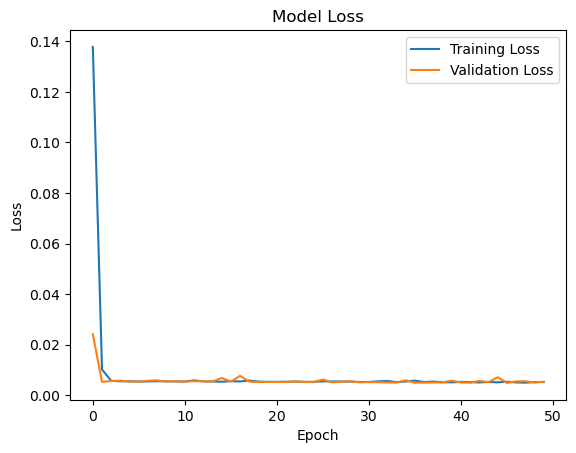

In [25]:
# Plot training and validation loss
plt.plot(history.history['loss'], label='Training Loss')  # Add label for training loss plot
plt.plot(history.history['val_loss'], label='Validation Loss')  # Add label for validation loss plot
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()  # This line creates the legend based on the provided labels
plt.title('Model Loss')  # Set the title of the plot
plt.show()

In [26]:
processed_df['Time'] = pd.to_datetime(processed_df['Time'], unit='s')
processed_df.set_index('Time',inplace=True)

In [28]:
predictions = []
all_results = pd.DataFrame()
for i in range(0, len(X_test)):
    X_batch = np.expand_dims(X_test[i], axis=0)
    forecast_values = model.predict(X_batch)
    forecast_values = scaler.inverse_transform(forecast_values)
    forecast_values = forecast_values.flatten()
    forecast_index = processed_df[6*(train_index+non_train_index+i)+time_step:6*(train_index+non_train_index+i)+time_step+6].index
    forecast_df = pd.DataFrame(forecast_values, index=forecast_index, columns=['Forecasted_Price'])
    df = pd.DataFrame(X_test[i], columns=['Price'])
    price_changes = df['Price'].pct_change()
    volatility = np.std(price_changes)
    multiplier = 1
    threshold = volatility * multiplier
    max_price = forecast_df['Forecasted_Price'].max()
    min_price = forecast_df['Forecasted_Price'].min()
    max_time = forecast_df['Forecasted_Price'].idxmax()
    min_time = forecast_df['Forecasted_Price'].idxmin()
    max_time = pd.to_datetime(max_time)
    min_time = pd.to_datetime(min_time)
    
    decision = 1 if min_time < max_time else 2
    act_buy = False if min_price <  (1-threshold)*processed_df.loc[min_time]['Weighted_Price']  else True
    act_sell = False if max_price >  (1+threshold)*processed_df.loc[max_time]['Weighted_Price'] else True
    result = pd.DataFrame({
    'Highest_Price': [max_price],  
    'Lowest_Price': [min_price],
    'Threshold':threshold ,
    'Decision': [decision],
    'act_buy': [act_buy],
    'act_sell': [act_sell]
}, index=[max_time])  
    all_results = pd.concat([all_results, result])
    predictions.extend(forecast_values)  

predictions = np.array(predictions)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━

In [30]:
rmse = np.sqrt(mean_squared_error(processed_df[6*(train_index + non_train_index)+time_step:], predictions))
print('Root Mean Squared Error:', rmse)
from sklearn.metrics import r2_score
r_squared = r2_score(processed_df[6*(train_index + non_train_index)+time_step:], predictions)
print('R² Score:', r_squared)

Root Mean Squared Error: 4.482914643221176
R² Score: 0.2380155890643162


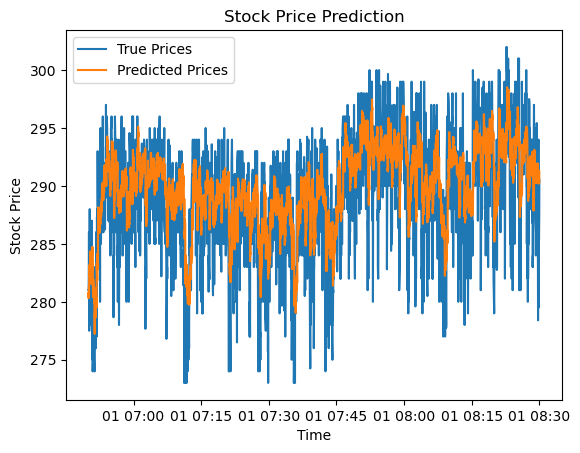

In [31]:
plt.plot(processed_df[6*(train_index + non_train_index)+time_step:].index, processed_df[6*(train_index + non_train_index)+time_step:], label='True Prices')
plt.plot(processed_df[6*(train_index + non_train_index)+time_step:].index, predictions, label='Predicted Prices')
plt.title('Stock Price Prediction')
plt.xlabel('Time')
plt.ylabel('Stock Price')
plt.legend()
plt.show()

In [32]:
all_results

,Highest_Price,Lowest_Price,Threshold,Decision,act_buy,act_sell
1970-01-01 06:50:06.901000,281.365112,280.345734,0.064157,1,True,True
1970-01-01 06:50:18.324500,283.232269,282.164673,0.064522,2,True,True
1970-01-01 06:50:26.059000,284.354767,283.160706,0.065270,2,True,True
1970-01-01 06:50:36.444000,284.019562,283.052704,0.066068,2,True,True
1970-01-01 06:50:45.248000,282.643768,281.541748,0.065832,1,True,True
...,...,...,...,...,...,...
1970-01-01 08:29:15.026000,291.192169,290.289673,0.070121,1,True,True
1970-01-01 08:29:23.086000,291.157532,290.262726,0.070406,1,True,True
1970-01-01 08:29:35.354250,291.959015,290.895935,0.070923,2,True,True
1970-01-01 08:29:45.731500,291.143677,290.193481,0.070587,2,True,True


In [33]:
initial_capital = 10000
transaction_num = 1
hold_stocks = False
transaction_result = []
stock_num = 0


for index, row in all_results.iterrows():
    operation = row['Decision']
    highest_price = row['Highest_Price']
    lowest_price = row['Lowest_Price']
    act_buy = row['act_buy']
    act_sell = row['act_sell']
    
    if highest_price-lowest_price >= 1 and operation == 1:
        
        if  act_buy == True and act_sell == True  and initial_capital >= highest_price:

            initial_capital -= transaction_num * lowest_price
            stock_num += transaction_num
            initial_capital += stock_num*highest_price
            sell_num = stock_num
            stock_num = 0
            if stock_num != 0:
                hold_stocks = True
            else:
                hold_stocks = False
            transaction_result.append({'operation': 'buy first and sell all', 'buy price':lowest_price,'sell price':highest_price ,'sell number':sell_num ,'buy_num':transaction_num})

        if  act_buy == False and act_sell == True   and hold_stocks == True :

            initial_capital += stock_num*highest_price
            sell_num = stock_num
            stock_num = 0
            if stock_num != 0:
                hold_stocks = True
            else:
                hold_stocks = False
            transaction_result.append({'operation': 'buy faild only sell', 'buy price': 0,'sell price': highest_price,'sell number':sell_num ,'buy_num': 0 })

        if  act_buy == False and act_sell == True  and initial_capital >= highest_price :
            initial_capital -= transaction_num * lowest_price
            stock_num += transaction_num
            if stock_num != 0:
                hold_stocks = True
            else:
                hold_stocks = False
            transaction_result.append({'operation': 'sell faild only buy', 'buy price':lowest_price ,'sell price': 0,'sell number':0 ,'buy_num': transaction_num })

        if  act_buy == False and act_sell == False:
            if stock_num != 0:
                hold_stocks = True
            else:
                hold_stocks = False
            transaction_result.append({'operation': 'sell faild and buy faild', 'buy price':0 ,'sell price': 0,'sell number':0 ,'buy_num': 0 })

if hold_stocks == True:
    final_price = data_copy['Weighted_Price'].iloc[-1]
    initial_capital += final_price*stock_num
    sell_num = stock_num
    stock_num = 0
    hold_stocks = False
    transaction_result.append({'operation': 'sell all', 'buy price':final_price ,'sell price': 0,'sell number':sell_num ,'buy_num': stock_num })
    
transaction_result_df = pd.DataFrame(transaction_result)
print(transaction_result_df)

# Calculate final capital and profit
final_capital = initial_capital
profit = final_capital - 10000
profitability = profit/10000
profitability_percent = "{:.4f}%".format(profitability * 100)
print(f'capital at closing：{final_capital}')
print(f'total_profit：{profit}')
print(f'Profitability：{profitability_percent}')

# profitability_data = {
#     'Final Capital': final_capital,
#     'Profit': profit,
#     'Profitability': profitability,
#     'Profitability Percent': profitability_percent
# }

#     # Convert the dictionary to a DataFrame
# profitability_df = pd.DataFrame([profitability_data])

    
# if match:
#     date_string = match.group(0)
#     new_file_name = f'{date_string}_transaction_result.csv'
#     new_file_name1 = f'{date_string}_profitability.csv'
#     transaction_result_df.to_csv(os.path.join(output_folder, new_file_name))
#     profitability_df.to_csv(os.path.join(output_folder, new_file_name1))

                  operation   buy price  sell price  sell number  buy_num
0    buy first and sell all  280.345734  281.365112            1        1
1    buy first and sell all  281.541748  282.643768            1        1
2    buy first and sell all  280.394867  281.949249            1        1
3    buy first and sell all  279.910522  281.262329            1        1
4    buy first and sell all  277.229706  279.020966            1        1
..                      ...         ...         ...          ...      ...
158  buy first and sell all  289.163574  290.198090            1        1
159  buy first and sell all  290.648132  291.988495            1        1
160  buy first and sell all  288.698761  290.337952            1        1
161  buy first and sell all  289.619171  290.690582            1        1
162  buy first and sell all  287.869019  289.446655            1        1

[163 rows x 5 columns]
capital at closing：10234.593322753906
total_profit：234.59332275390625
Profitability：2.34